**IMPLEMENTASI PREPROCESSING DAN KLASIFIKASI TEKS PUTUSAN**

**Instalasi Library**

In [ ]:
!pip install Sastrawi scikit-learn pandas nltk

**1. Import Library**




In [ ]:
import pandas as pd
import numpy as np
import re
import itertools
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# Model
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Text Preprocessing
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

**1. Baca Dataset & EDA**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# --- Install library tambahan ---
!pip install Sastrawi
!pip install nltk

# --- Import dan unduh stopwords ---
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# --- Import library ---
import pandas as pd
import re
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

In [ ]:

# --- 1. Baca dataset ---
df = pd.read_csv("/content/drive/MyDrive/MESIN/CSV/putusan_ma__2025-10-24.csv")
print(df.head())


                                               judul                   nomor  \
0  Putusan PN SAMARINDA Nomor 646/Pid.B/2024/PN S...   646/Pid.B/2024/PN Smr   
1  Putusan PN SAMARINDA Nomor 598/Pid.B/2024/PN S...   598/Pid.B/2024/PN Smr   
2  Putusan PN SAMARINDA Nomor 768/Pid.B/2024/PN S...   768/Pid.B/2024/PN Smr   
3  Putusan PN SAMARINDA Nomor 1012/Pid.B/2024/PN ...  1012/Pid.B/2024/PN Smr   
4  Putusan PN SAMARINDA Nomor 764/Pid.B/2024/PN S...   764/Pid.B/2024/PN Smr   

  tingkat_proses                            klasifikasi kata_kunci  tahun  \
0        Pertama  Pidana Umum \n Pidana Umum  Pencurian  Pencurian   2024   
1        Pertama  Pidana Umum \n Pidana Umum  Pencurian  Pencurian   2024   
2        Pertama  Pidana Umum \n Pidana Umum  Pencurian  Pencurian   2024   
3        Pertama  Pidana Umum \n Pidana Umum  Pencurian  Pencurian   2024   
4        Pertama  Pidana Umum \n Pidana Umum  Pencurian  Pencurian   2024   

   tanggal_register lembaga_peradilan jenis_lembaga_pera

In [ ]:
# --- 1. Import library ---
import pandas as pd

# --- 2. Muat dataset ---
df = pd.read_csv('/content/putusan_ma__2025-10-07.csv')  # ganti sesuai nama file kamu

# --- 3. Cek informasi umum dataset ---
print("=== INFO DATASET ===")
print(df.info())
print("\nJumlah baris dan kolom:", df.shape)

# --- 4. Cek missing value ---
print("\n=== CEK MISSING VALUE ===")
print(df.isnull().sum())

# --- 5. Cek data duplikat ---
duplicate_rows = df.duplicated().sum()
print(f"\nJumlah data duplikat: {duplicate_rows}")
if duplicate_rows > 0:
    print("Menghapus data duplikat...")
    df = df.drop_duplicates()
    print("Duplikat dihapus. Jumlah data baru:", df.shape)

# --- 6. Cek nilai unik pada kolom label ---
if 'label' in df.columns:
    print("\n=== NILAI UNIK PADA KOLOM LABEL ===")
    print(df['label'].value_counts())
else:
    print("\nKolom 'label' tidak ditemukan!")

# --- 7. Cek panjang teks (outlier teks kosong) ---
if 'clean_text' in df.columns:
    df['text_length'] = df['clean_text'].astype(str).apply(len)
    print("\n=== STATISTIK PANJANG TEKS ===")
    print(df['text_length'].describe())

    kosong = df[df['text_length'] == 0].shape[0]
    print(f"\nJumlah teks kosong: {kosong}")
    if kosong > 0:
        print("Menghapus teks kosong...")
        df = df[df['text_length'] > 0]
else:
    print("\nKolom 'clean_text' tidak ditemukan!")

# --- 8. Cek tipe data label encoded ---
if 'label_encoded' in df.columns:
    print("\n=== TIPE DATA label_encoded ===")
    print(df['label_encoded'].dtype)
else:
    print("\nKolom 'label_encoded' tidak ditemukan!")

# --- 9. Simpan ulang dataset hasil pembersihan ---
df.to_csv('refined_pencurian_clean.csv', index=False)
print("\nDataset bersih disimpan ke 'refined_pencurian_clean.csv'")


=== INFO DATASET ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   judul                    162 non-null    object 
 1   nomor                    162 non-null    object 
 2   tingkat_proses           162 non-null    object 
 3   klasifikasi              162 non-null    object 
 4   kata_kunci               162 non-null    object 
 5   tahun                    162 non-null    int64  
 6   tanggal_register         162 non-null    object 
 7   lembaga_peradilan        162 non-null    object 
 8   jenis_lembaga_peradilan  162 non-null    object 
 9   hakim_ketua              162 non-null    object 
 10  hakim_anggota            162 non-null    object 
 11  panitera                 162 non-null    object 
 12  amar                     162 non-null    object 
 13  amar_lainnya             161 non-null    object 
 14  catat

In [ ]:

# --- 2. Pilih kolom penting ---
df = df[['judul', 'klasifikasi', 'text_pdf']].dropna()

import re

def clean_legal_text(text):
    text = re.sub(r'rektor putus mahkamah agung republik indonesia', '', text)
    text = re.sub(r'putusan nomor.*', '', text)
    text = re.sub(r'majelis hakim.*', '', text)
    text = re.sub(r'\b(perkara|pidana|pengadilan|putusan|nomor)\b', '', text)
    return text.strip()

# --- 3. Buat kolom label otomatis ---
def klasifikasi_pencurian(text):
    text_lower = str(text).lower()
    # kata kunci pencurian berat
    indikator_berat = [
        "pencurian dengan kekerasan",
        "pencurian disertai kekerasan",
        "pencurian dalam rumah",
        "pencurian pada malam hari",
        "senjata tajam",
        "bersekongkol",
        "berat"
    ]
    for kata in indikator_berat:
        if kata in text_lower:
            return "pencurian berat"
    return "pencurian biasa"

df['label'] = df['text_pdf'].apply(klasifikasi_pencurian)

# --- 4. Preprocessing teks ---
factory = StemmerFactory()
stemmer = factory.create_stemmer()
stop_words = set(stopwords.words('indonesian'))

def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', ' ', str(text))
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    stemmed = [stemmer.stem(word) for word in tokens]
    return ' '.join(stemmed)

df['clean_text'] = df['text_pdf'].apply(clean_text)

# --- 5. Simpan hasil akhir ---
df.to_csv("preprocessed_pencurian.csv", index=False)

# --- 6. Tampilkan contoh hasil ---
print(df[['judul', 'label', 'clean_text']].head(5))
print("Preprocessing & labeling selesai. File: preprocessed_pencurian.csv")


KeyboardInterrupt: 

In [ ]:
df['label'].value_counts()

,count
label,
pencurian berat,72
pencurian biasa,52


**SELEKSI FITUR**

In [ ]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# 1. Baca data
df = pd.read_csv("preprocessed_pencurian.csv")

# 2. Pisahkan fitur dan target
X = df.drop(columns=['label'])
y = df['label']

# 3. Encoding jika ada fitur kategorikal
X_encoded = X.copy()
for col in X_encoded.columns:
    if X_encoded[col].dtype == 'object':
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))

# Normalisasi agar tidak ada nilai negatif (syarat chi2)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_encoded)

# 4. Seleksi fitur dengan Chi-Square
chi2_selector = SelectKBest(score_func=chi2, k='all')
chi2_selector.fit(X_scaled, y)

# 5. Buat DataFrame hasil skor
chi2_scores = pd.DataFrame({
    'Fitur': X_encoded.columns,
    'Chi2_Score': chi2_selector.scores_
}).sort_values(by='Chi2_Score', ascending=False)

print("=== Skor Chi-Square untuk tiap fitur ===")
print(chi2_scores)

# 6. (Opsional) Ambil fitur terbaik, misal top 10
top_features = chi2_scores.head(10)['Fitur'].tolist()
print("\nTop 10 fitur paling berpengaruh:")
print(top_features)


=== Skor Chi-Square untuk tiap fitur ===
         Fitur  Chi2_Score
2     text_pdf   17.833470
3   clean_text   13.379018
0        judul    9.486141
1  klasifikasi    0.190302

Top 10 fitur paling berpengaruh:
['text_pdf', 'clean_text', 'judul', 'klasifikasi']


In [ ]:
import re

# --- Tambahkan fungsi pembersihan teks hukum ---
def refine_legal_text(text):
    text = text.lower()

    # Hapus header administratif dan pola umum
    text = re.sub(r'direktori putusan mahkamah agung republik indonesia', ' ', text)
    text = re.sub(r'putusan\s+nomor\s+[^\n]+', ' ', text)
    text = re.sub(r'pengadilan negeri [a-z\s]+', ' ', text)
    text = re.sub(r'majelis hakim[^\n]+', ' ', text)
    text = re.sub(r'dalam perkara[^\n]+', ' ', text)
    text = re.sub(r'rektor putus mahkamah agung republik indonesia', ' ', text)

    # Ambil isi utama dari "menimbang" hingga "menetapkan"
    match = re.search(r'menimbang(.*)menetapkan', text)
    if match:
        text = match.group(1)

    # Hapus angka, simbol, dan spasi berlebih
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# --- Terapkan fungsi ke seluruh data ---
df['clean_refined'] = df['text_pdf'].astype(str).apply(refine_legal_text)

# Cek hasil
print(df[['label', 'clean_refined']].head())


             label                                      clean_refined
0  pencurian biasa  putusan mahkamahagung go id mahkamah agung rep...
1  pencurian biasa  putusan mahkamahagung go id mahkamah agung rep...
2  pencurian biasa  putusan mahkamahagung go id mahkamah agung rep...
3  pencurian berat  putusan mahkamahagung go id mahkamah agung rep...
4  pencurian biasa  putusan mahkamahagung go id mahkamah agung rep...


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_refined'], df['label_encoded'],
    test_size=0.2, random_state=42, stratify=df['label_encoded']
)


KeyError: 'label_encoded'

In [ ]:
print(df[['clean_text', 'clean_refined']].head(3))


                                          clean_text  \
0  rektor putus mahkamah agung republik indonesia...   
1  rektor putus mahkamah agung republik indonesia...   
2  rektor putus mahkamah agung republik indonesia...   

                                       clean_refined  
0  putusan mahkamahagung go id mahkamah agung rep...  
1  putusan mahkamahagung go id mahkamah agung rep...  
2  putusan mahkamahagung go id mahkamah agung rep...  


In [ ]:
from sklearn.feature_selection import chi2, SelectKBest
selector = SelectKBest(chi2, k=300)
X_sel = selector.fit_transform(X_tfidf, df['label'])


NameError: name 'X_tfidf' is not defined

In [ ]:
import re
import string
import nltk
from nltk.corpus import stopwords

# --- Unduh stopword Bahasa Indonesia ---
nltk.download('stopwords')
stop_words = set(stopwords.words('indonesian'))

# --- Fungsi untuk memperhalus hasil cleaning ---
def refine_text(text):
    # 1. Ubah ke huruf kecil
    text = text.lower()
    # 2. Hilangkan angka dan tanda baca
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    # 3. Hilangkan kata pendek (1–2 huruf)
    text = re.sub(r'\b\w{1,2}\b', '', text)
    # 4. Tokenisasi dan hapus stopword
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    # 5. Gabungkan kembali
    return ' '.join(tokens)

# --- Terapkan ke kolom clean_text ---
df['clean_refined'] = df['clean_text'].apply(refine_text)

# --- Cek hasil ---
print(df[['clean_text', 'clean_refined']].head())


                                          clean_text  \
0  rektor putus mahkamah agung republik indonesia...   
1  rektor putus mahkamah agung republik indonesia...   
2  rektor putus mahkamah agung republik indonesia...   
3  rektor putus mahkamah agung republik indonesia...   
4  rektor putus mahkamah agung republik indonesia...   

                                       clean_refined  
0  rektor putus mahkamah agung republik indonesia...  
1  rektor putus mahkamah agung republik indonesia...  
2  rektor putus mahkamah agung republik indonesia...  
3  rektor putus mahkamah agung republik indonesia...  
4  rektor putus mahkamah agung republik indonesia...  


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# --- lanjut langsung tanpa df = pd.read_csv(...) ---
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

vectorizer = TfidfVectorizer(ngram_range=(2,2), max_features=5000)
X_tfidf = vectorizer.fit_transform(df['clean_refined'])
y = df['label_encoded']

selector = SelectKBest(chi2, k=1000)
X_selected = selector.fit_transform(X_tfidf, y)

selected_features = vectorizer.get_feature_names_out()[selector.get_support()]

print("Jumlah fitur setelah seleksi:", X_selected.shape[1])
print("\n10 fitur paling informatif:")
print(selected_features[:10])


Jumlah fitur setelah seleksi: 1000

10 fitur paling informatif:
['abu abu' 'acara pidana' 'add unsur' 'adil agama' 'adil dakwa'
 'adil dasar' 'adil negeri' 'adil perkara' 'aditya saputra' 'agama batam']


In [ ]:
# Setelah membuat kolom clean_refined
df.to_csv('refined_pencurian.csv', index=False)


In [ ]:
df = pd.read_csv('refined_pencurian.csv')


NAIVE BAYES ORIGINAL DATA

Naive Bayes (Original Data)
Akurasi: 100.0 %

Confusion Matrix:
 [[13  0]
 [ 0 11]]

Classification Report:
                  precision    recall  f1-score   support

pencurian biasa       1.00      1.00      1.00        13
pencurian berat       1.00      1.00      1.00        11

       accuracy                           1.00        24
      macro avg       1.00      1.00      1.00        24
   weighted avg       1.00      1.00      1.00        24



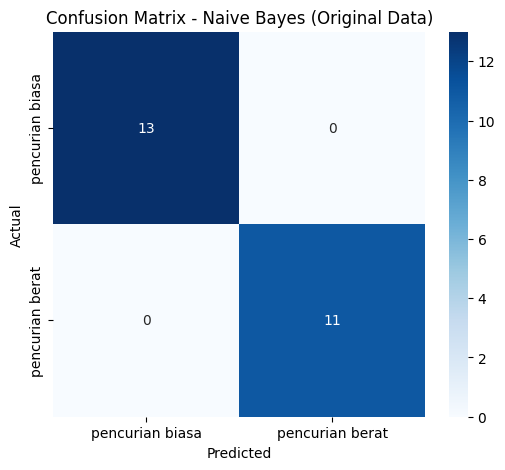

In [ ]:
# --- 1. Import library ---
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- 2. Split data (gunakan TF-IDF original, bukan hasil seleksi fitur) ---
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf,  # data asli TF-IDF
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# --- 3. Latih model Naive Bayes ---
nb_orig = MultinomialNB()
nb_orig.fit(X_train, y_train)

# --- 4. Prediksi ---
y_pred = nb_orig.predict(X_test)

# --- 5. Evaluasi ---
akurasi_nb_orig = accuracy_score(y_test, y_pred)
print("Naive Bayes (Original Data)")
print("Akurasi:", round(akurasi_nb_orig * 100, 2), "%")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n",
      classification_report(y_test, y_pred, target_names=df['label'].unique()))

# --- 6. Visualisasi Confusion Matrix ---
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=df['label'].unique(),
            yticklabels=df['label'].unique())
plt.title("Confusion Matrix - Naive Bayes (Original Data)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


NAIVE BAYES SELEKSI FITUR

Akurasi: 0.9583333333333334

Classification Report:
                  precision    recall  f1-score   support

pencurian biasa       1.00      0.92      0.96        13
pencurian berat       0.92      1.00      0.96        11

       accuracy                           0.96        24
      macro avg       0.96      0.96      0.96        24
   weighted avg       0.96      0.96      0.96        24



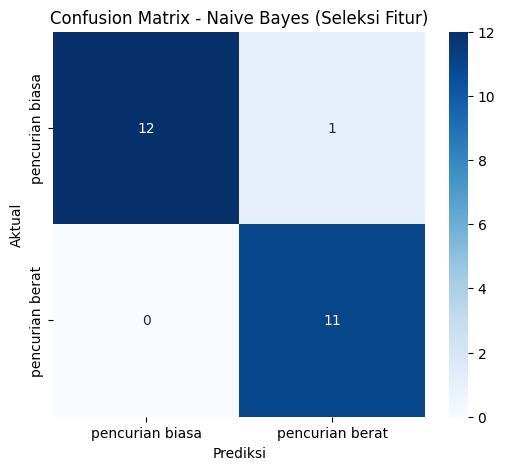

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Split data ---
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

# --- 2. Latih model ---
nb = MultinomialNB()
nb.fit(X_train, y_train)

# --- 3. Prediksi ---
y_pred = nb.predict(X_test)

# --- 4. Evaluasi hasil ---
print("Akurasi:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=df['label'].unique()))

# --- 5. Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
labels = df['label'].unique()

# --- 6. Visualisasi Confusion Matrix ---
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Naive Bayes (Seleksi Fitur)")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()


SVM ORIGINAL DATA

=== HASIL SVM (Original Data) ===
Akurasi: 1.0

Classification Report:
                 precision    recall  f1-score   support

pencurian biasa       1.00      1.00      1.00        13
pencurian berat       1.00      1.00      1.00        11

       accuracy                           1.00        24
      macro avg       1.00      1.00      1.00        24
   weighted avg       1.00      1.00      1.00        24



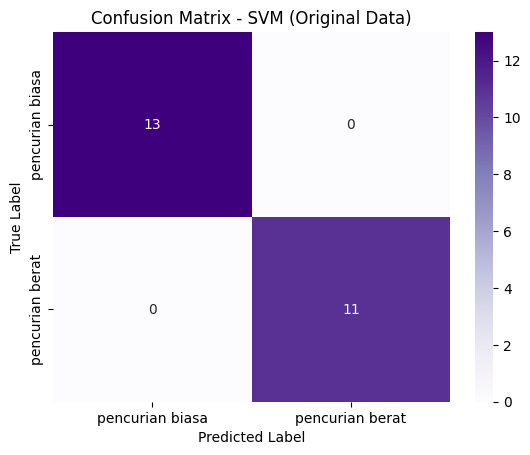

['tfidf_original.pkl']

In [ ]:
# --- 1. Import library ---
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# --- 2. Muat dataset ---
df = pd.read_csv('refined_pencurian.csv')

# --- 3. Siapkan data ---
X = df['clean_refined']
y = df['label_encoded']

# --- 4. Split data ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 5. TF-IDF Original (5000 fitur) ---
tfidf_full = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_full = tfidf_full.fit_transform(X_train)
X_test_full = tfidf_full.transform(X_test)

# --- 6. Latih model SVM ---
svm_full = LinearSVC()
svm_full.fit(X_train_full, y_train)

# --- 7. Prediksi ---
y_pred_svm_full = svm_full.predict(X_test_full)

# --- 8. Evaluasi ---
print("=== HASIL SVM (Original Data) ===")
print("Akurasi:", accuracy_score(y_test, y_pred_svm_full))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm_full, target_names=df['label'].unique(), zero_division=0))

# --- 9. Visualisasi Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred_svm_full)
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=df['label'].unique(),
            yticklabels=df['label'].unique())
plt.title("Confusion Matrix - SVM (Original Data)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# --- 10. Simpan model ---
joblib.dump(svm_full, 'svm_original.pkl')
joblib.dump(tfidf_full, 'tfidf_original.pkl')


SVM SELEKSI FITUR

=== HASIL SVM (Seleksi Fitur) ===
Akurasi: 0.5416666666666666

Classification Report:
                 precision    recall  f1-score   support

pencurian biasa       0.54      1.00      0.70        13
pencurian berat       0.00      0.00      0.00        11

       accuracy                           0.54        24
      macro avg       0.27      0.50      0.35        24
   weighted avg       0.29      0.54      0.38        24



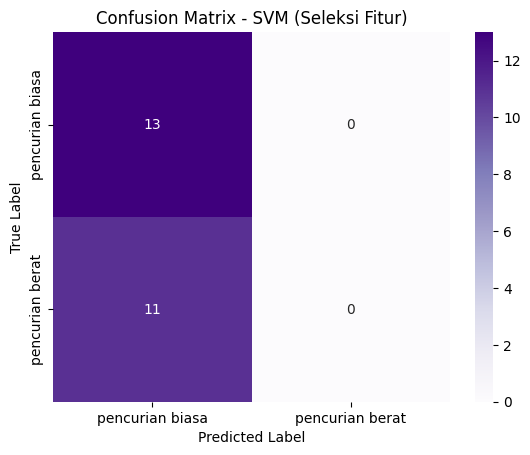

['tfidf_selected.pkl']

In [ ]:
# --- 1. Import library ---
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# --- 2. Muat dataset ---
df = pd.read_csv('refined_pencurian.csv')

# --- 3. Siapkan data ---
X = df['clean_refined']
y = df['label_encoded']

# --- 4. Muat fitur hasil seleksi ---
selected_features = pd.read_csv('selected_features.csv')['selected_features'].values.tolist()

# --- 5. Split data ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 6. TF-IDF hanya pada fitur terpilih ---
tfidf_sel = TfidfVectorizer(vocabulary=selected_features)
X_train_sel = tfidf_sel.fit_transform(X_train)
X_test_sel = tfidf_sel.transform(X_test)

# --- 7. Latih model SVM ---
svm_sel = LinearSVC()
svm_sel.fit(X_train_sel, y_train)

# --- 8. Prediksi ---
y_pred_svm_sel = svm_sel.predict(X_test_sel)

# --- 9. Evaluasi ---
print("=== HASIL SVM (Seleksi Fitur) ===")
print("Akurasi:", accuracy_score(y_test, y_pred_svm_sel))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm_sel, target_names=df['label'].unique(), zero_division=0))

# --- 10. Visualisasi Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred_svm_sel)
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=df['label'].unique(),
            yticklabels=df['label'].unique())
plt.title("Confusion Matrix - SVM (Seleksi Fitur)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# --- 11. Simpan model ---
joblib.dump(svm_sel, 'svm_selected.pkl')
joblib.dump(tfidf_sel, 'tfidf_selected.pkl')


In [ ]:
!pip install pdfminer.six


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 50.1 MB/s eta 0:00:00


In [ ]:
# ii. Konversi & Ekstraksi Teks
import argparse
import io
import os
import re
import time
import urllib
from concurrent.futures import ThreadPoolExecutor, wait
from datetime import date
import pandas as pd
import requests
from bs4 import BeautifulSoup
from pdfminer import high_level

from pdfminer.high_level import extract_text
import os


from google.colab import drive
drive.mount('/content/drive')

# Path folder PDF di Google Drive
folder_pdf = "/content/drive/MyDrive/MESIN/PDF"

# Loop semua file di folder
for file_name in os.listdir(folder_pdf):
    if file_name.lower().endswith(".pdf"):
        path_pdf = os.path.join(folder_pdf, file_name)
        path_txt = os.path.join(folder_pdf, file_name.replace(".pdf", ".txt"))

        try:
            print(f"Memproses: {file_name}")
            text = extract_text(path_pdf)

            # Simpan hasil ke .txt
            with open(path_txt, "w", encoding="utf-8") as f:
                f.write(text)

            print(f"Sukses disimpan ke: {path_txt}\n")

        except Exception as e:
            print(f"Gagal memproses {file_name}: {e}\n")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Memproses: putusan_598_pid.b_2024_pn_smr_20251007204404.pdf
Sukses disimpan ke: /content/drive/MyDrive/MESIN/PDF/putusan_598_pid.b_2024_pn_smr_20251007204404.txt

Memproses: putusan_768_pid.b_2024_pn_smr_20251007204420.pdf
Sukses disimpan ke: /content/drive/MyDrive/MESIN/PDF/putusan_768_pid.b_2024_pn_smr_20251007204420.txt

Memproses: putusan_877_pid.b_2024_pn_smr_20251007204508.pdf
Sukses disimpan ke: /content/drive/MyDrive/MESIN/PDF/putusan_877_pid.b_2024_pn_smr_20251007204508.txt

Memproses: putusan_646_pid.b_2024_pn_smr_20251007204506.pdf
Sukses disimpan ke: /content/drive/MyDrive/MESIN/PDF/putusan_646_pid.b_2024_pn_smr_20251007204506.txt

Memproses: putusan_1012_pid.b_2024_pn_smr_20251007204517.pdf
Sukses disimpan ke: /content/drive/MyDrive/MESIN/PDF/putusan_1012_pid.b_2024_pn_smr_20251007204517.txt

Memproses: putusan_678_pid.b_2024_pn_smr_2025100720461

In [ ]:
# iii. Pembersihan

import os
import re
import pandas as pd

# === 1. Path Folder ===
input_folder = "/content/drive/MyDrive/MESIN/PDF"           # Folder file txt awal
output_folder = "/content/drive/MyDrive/MESIN/hasil_txt"    # Folder hasil pembersihan
os.makedirs(output_folder, exist_ok=True)

# === 2. Fungsi Pembersihan Teks ===
def clean_text(text):
    if not isinstance(text, str):
        return ""

    # Hapus header/footer/nomor halaman/watermark
    text = re.sub(r'M\s*a\s*h\s*k\s*a\s*m\s*a\s*h.*?Indo[nn]esia', '', text, flags=re.IGNORECASE)
    text = re.sub(r'Disclaimer.*?\n', '', text, flags=re.IGNORECASE)
    text = re.sub(r'Email\s*:.*?(ext.*?)?\n', '', text, flags=re.IGNORECASE)
    text = re.sub(r'Page\s+\d+\s+of\s+\d+', '', text, flags=re.IGNORECASE)

    # Normalisasi teks
    text = text.lower()
    text = re.sub(r'\n+', '\n', text)               # Banyak newline → satu
    text = re.sub(r'\s+', ' ', text)                # Spasi berlebih → satu

    return text.strip()

# === 3. Baca Semua File .txt dan Bersihkan ===
records = []
file_list = sorted([f for f in os.listdir(input_folder) if f.endswith(".txt")])

for i, file_name in enumerate(file_list, start=1):
    file_path = os.path.join(input_folder, file_name)
    with open(file_path, "r", encoding="utf-8") as f:
        raw_text = f.read()

    cleaned = clean_text(raw_text)

    # Simpan file hasil pembersihan
    output_file_name = f"case_{str(i).zfill(3)}.txt"
    output_path = os.path.join(output_folder, output_file_name)
    with open(output_path, "w", encoding="utf-8") as f:
        f.write(cleaned)

    # Simpan ke dataframe
    records.append({
        "original_file": file_name,
        "case_file": output_file_name,
        "cleaned_text": cleaned
    })

# === 4. Simpan Metadata ke CSV ===
df = pd.DataFrame(records)
df["amar_ringkas"] = df["cleaned_text"].apply(lambda text: re.search(r'menyatakan bersalah(.*?)\.', text).group(0).strip() if re.search(r'menyatakan bersalah(.*?)\.', text) else "")

df.to_csv(os.path.join(output_folder, "putusan_cleaned.csv"), index=False)

print(f"Sukses! Semua file .txt dan metadata CSV disimpan di: {output_folder}")

Sukses! Semua file .txt dan metadata CSV disimpan di: /content/drive/MyDrive/MESIN/hasil_txt


In [ ]:
# iv. validasi
import os

folder_clean = "/content/drive/MyDrive/MESIN/hasil_txt"
log_validasi = "/content/drive/MyDrive/data/processed/validasi_teks.csv"

os.makedirs(os.path.dirname(log_validasi), exist_ok=True)

records = []
min_kata_valid = 500

file_list = sorted([f for f in os.listdir(folder_clean) if f.endswith(".txt")])

for file_name in file_list:
    file_path = os.path.join(folder_clean, file_name)
    with open(file_path, "r", encoding="utf-8") as f:
        text = f.read()

    jumlah_kata = len(text.split())
    status = "VALID" if jumlah_kata >= min_kata_valid else "TIDAK VALID"

    records.append({
        "file_name": file_name,
        "jumlah_kata": jumlah_kata,
        "status": status
    })

df_validasi = pd.DataFrame(records)
df_validasi.to_csv(log_validasi, index=False)

print(f"Selesai validasi. Log disimpan di: {log_validasi}")
print(df_validasi['status'].value_counts())

Selesai validasi. Log disimpan di: /content/drive/MyDrive/data/processed/validasi_teks.csv
status
VALID          279
TIDAK VALID      2
Name: count, dtype: int64


In [ ]:
# v. output

import shutil

output_raw = "/content/drive/MyDrive/MESIN/data/raw"
os.makedirs(output_raw, exist_ok=True)

for file_name in file_list:
    src_path = os.path.join(folder_clean, file_name)
    dst_path = os.path.join(output_raw, file_name)
    shutil.copy(src_path, dst_path)

print(f"Semua file sudah disalin ke folder: {output_raw}")


Semua file sudah disalin ke folder: /content/drive/MyDrive/MESIN/data/raw


In [ ]:
# i. Ekstraksi Metadata
import re

def extract_metadata(text):
    # Contoh pola regex, sesuaikan dengan struktur umum putusan
    no_perkara = re.search(r'no(?:mor)?\s*[:\.]?\s*([a-z0-9\/\.-]+)', text)
    tanggal = re.search(r'tanggal\s+(putusan|dibacakan|sidang)?\s*[:\.]?\s*([\d]{1,2}\s+\w+\s+\d{4})', text)
    jenis = re.search(r'jenis\s+perkara\s*[:\.]?\s*([a-z\s]+)', text)
    pasal = re.search(r'pasal\s*[:\.]?\s*(\d+[\s\w\d]*)', text)
    pihak = re.findall(r'(tergugat|penggugat|terdakwa|penuntut umum)\s*[:\.]?\s*([A-Z\s]+)', text)

    return {
        "no_perkara": no_perkara.group(1) if no_perkara else "",
        "tanggal": tanggal.group(2) if tanggal else "",
        "jenis_perkara": jenis.group(1) if jenis else "",
        "pasal": pasal.group(1) if pasal else "",
        "pihak": ", ".join([f"{p[0]}: {p[1].strip()}" for p in pihak]) if pihak else ""
    }

In [ ]:
# ii. Ekstraksi Konten Kunci

def extract_ringkasan_fakta(text):
    match = re.search(r'(?:fakta|barang bukti|pertimbangan hukum).*?:?(.{0,500})', text, re.IGNORECASE)
    return match.group(1).strip() if match else ""

def extract_argumen_hukum(text):
    match = re.search(r'(?:menimbang|putusan).*?(pasal.*?)\.', text, re.IGNORECASE | re.DOTALL)
    return match.group(1).strip() if match else ""

In [ ]:
# iii. Feature Engineering


from collections import Counter

def feature_engineering(text):
    words = text.lower().split()  # Convert to lowercase untuk konsistensi

    # Basic features
    basic_features = {
        "length_words": len(words),
        "length_chars": len(text)
    }

    # Bag-of-Words sederhana untuk kata kunci hukum
    legal_keywords = [
      'pencurian', 'barang', 'bukti', 'tersangka', 'terdakwa', 'korban',
      'rumah', 'kendaraan', 'motor', 'mobil', 'uang', 'emas', 'barang bukti',
      'malam hari', 'bersekutu', 'kekerasan', 'ancaman', 'perkara',
      'pasal', 'ayat', 'pidana', 'penjara', 'berat', 'ringan',
      'pembobolan', 'perampasan', 'pembongkaran', 'pemaksaan',
      'tertangkap tangan', 'pengakuan', 'saksi', 'laporan', 'kerugian',
      'niat', 'perbuatan', 'terencana', 'tanpa izin', 'mengambil',
      'memiliki', 'barang orang lain', 'penyidikan', 'penuntutan',
      'putusan', 'pengadilan', 'hakim', 'penuntut umum'
  ]

    # Hitung kemunculan setiap keyword
    word_counts = Counter(words)
    bow_features = {}

    for keyword in legal_keywords:
        bow_features[f"bow_{keyword}"] = word_counts.get(keyword, 0)

    # Gabungkan basic features dengan bag-of-words
    return {**basic_features, **bow_features}

In [ ]:
# iv. penyimpanan

import pandas as pd
import os

folder_clean = "/content/drive/MyDrive/MESIN/hasil_txt"
output_csv = "/content/drive/MyDrive/MESIN/data/processed/cases.csv"
os.makedirs(os.path.dirname(output_csv), exist_ok=True)

records = []
file_list = sorted([f for f in os.listdir(folder_clean) if f.endswith(".txt")])

for i, file_name in enumerate(file_list, start=1):
    file_path = os.path.join(folder_clean, file_name)
    with open(file_path, "r", encoding="utf-8") as f:
        text = f.read()

    meta = extract_metadata(text)
    fakta = extract_ringkasan_fakta(text)
    hukum = extract_argumen_hukum(text)
    feats = feature_engineering(text)

    records.append({
        "case_id": f"case_{str(i).zfill(3)}",
        "no_perkara": meta["no_perkara"],
        "tanggal": meta["tanggal"],
        "jenis_perkara": meta["jenis_perkara"],
        "ringkasan_fakta": fakta,
        "pasal": meta["pasal"],
        "pihak": meta["pihak"],
        "argumen_hukum": hukum,
        "length_words": feats["length_words"],
        "length_chars": feats["length_chars"],
        "text_full": text
    })

# Simpan ke CSV
df = pd.DataFrame(records)
df.to_csv(output_csv, index=False)
print(f"Sukses simpan ke: {output_csv}")

Sukses simpan ke: /content/drive/MyDrive/MESIN/data/processed/cases.csv


In [ ]:
#i. Representasi Vektor
#1. TF-IDF Vectorizer

!pip install Sastrawi

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# === 1. Load Dataset ===
df = pd.read_csv("/content/drive/MyDrive/MESIN/data/processed/cases.csv")
texts = df['text_full'].fillna("").tolist()

# === 2. Stopword Bahasa Indonesia dari Sastrawi ===
factory = StopWordRemoverFactory()
indonesian_stopwords = factory.get_stop_words()

# === 3. TF-IDF Vectorizer ===
vectorizer = TfidfVectorizer(max_features=5000, stop_words=indonesian_stopwords)
tfidf_matrix = vectorizer.fit_transform(texts)

print(f"TF-IDF matriks shape: {tfidf_matrix.shape}")


TF-IDF matriks shape: (281, 5000)


In [ ]:
# Pencarian Kasus Mirip (Similarity Search) Jika Pakai TF-IDF

query_idx = 0  # Misal pakai kasus pertama sebagai query
query_vec = tfidf_matrix[query_idx]

# Hitung similarity
similarities = cosine_similarity(query_vec, tfidf_matrix).flatten()

# Top 3 kasus mirip (selain diri sendiri)
similar_indices = similarities.argsort()[::-1][1:4]
print(df.iloc[similar_indices][['case_id', 'no_perkara', 'tanggal']])


     case_id          no_perkara          tanggal
1   case_002  1001/pid.b/2023/pn  09 oktober 2023
92  case_093   464/pid.b/2024/pn      27 mei 2024
93  case_094   464/pid.b/2024/pn      27 mei 2024


In [ ]:
# ii. Splitting Data
# 1. Kode Splitting Data (80:20)
from sklearn.model_selection import train_test_split
import pandas as pd

# Load dataset yang sudah diproses sebelumnya
df = pd.read_csv('/content/drive/MyDrive/MESIN/data/processed/cases.csv')

# Jika ingin memisahkan berdasarkan label tertentu (misalnya klasifikasi), tentukan kolom target
# Tapi untuk general case retrieval, kita split berdasarkan 'text_full' saja

# Split 80% training, 20% testing
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# Simpan hasil split
output_dir = '/content/drive/MyDrive/MESIN/data/processed'
df_train.to_csv(f'{output_dir}/cases_train.csv', index=False)
df_test.to_csv(f'{output_dir}/cases_test.csv', index=False)

print(f"✅ Sukses split data:")
print(f"  → Train set: {len(df_train)} data")
print(f"  → Test set : {len(df_test)} data")


✅ Sukses split data:
  → Train set: 224 data
  → Test set : 57 data


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 1️⃣ Load dataset awal (belum di-split)
df = pd.read_csv('/content/drive/MyDrive/MESIN/data/processed/cases.csv')

# 2️⃣ Tambahkan kolom label berdasarkan pasal
def classify_case(pasal):
    if pd.isna(pasal):
        return None
    pasal = str(pasal).lower()
    if "363" in pasal or "365" in pasal:
        return "pencurian_berat"
    elif "362" in pasal:
        return "pencurian_biasa"
    else:
        return "lainnya"

df['label'] = df['pasal'].apply(classify_case)
df = df[df['label'].isin(['pencurian_biasa', 'pencurian_berat'])]

print("Jumlah data per kelas:")
print(df['label'].value_counts())

# 3️⃣ Split ulang data (pastikan label ikut tersimpan)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# 4️⃣ Simpan ulang hasil split
output_dir = '/content/drive/MyDrive/MESIN/data/processed'
df_train.to_csv(f'{output_dir}/cases_train.csv', index=False)
df_test.to_csv(f'{output_dir}/cases_test.csv', index=False)

print("\nData sudah di-split ulang dan kolom label sudah termasuk:")
print(f"Train: {len(df_train)} data | Test: {len(df_test)} data")


Jumlah data per kelas:
label
pencurian_berat    111
pencurian_biasa     51
Name: count, dtype: int64

Data sudah di-split ulang dan kolom label sudah termasuk:
Train: 129 data | Test: 33 data


In [ ]:
# --- Naive Bayes dengan data split eksternal ---

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd

# --- Load data hasil split ---
train_df = pd.read_csv('/content/drive/MyDrive/MESIN/data/processed/cases_train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/MESIN/data/processed/cases_test.csv')

# --- Ambil teks dan label ---
X_train = train_df['text_full'].fillna("")
y_train = train_df['label']
X_test = test_df['text_full'].fillna("")
y_test = test_df['label']

# --- TF-IDF Vectorization (n-gram=2) ---
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# --- Train Model ---
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# --- Evaluasi ---
y_pred = nb_model.predict(X_test_tfidf)

print("\n=== Classification Report (Naive Bayes) ===")
print(classification_report(y_test, y_pred))

print("\n=== Confusion Matrix (Naive Bayes) ===")
print(confusion_matrix(y_test, y_pred))

print("\nAkurasi:", accuracy_score(y_test, y_pred))

# --- Simpan hasil ---
results = pd.DataFrame({
    'text': X_test,
    'true_label': y_test,
    'predicted': y_pred
})
results.to_csv('/content/drive/MyDrive/MESIN/naive_bayes_results.csv', index=False)
print("\nHasil disimpan ke: /content/drive/MyDrive/MESIN/naive_bayes_results.csv")



=== Classification Report (Naive Bayes) ===
                 precision    recall  f1-score   support

pencurian_berat       0.70      1.00      0.82        23
pencurian_biasa       0.00      0.00      0.00        10

       accuracy                           0.70        33
      macro avg       0.35      0.50      0.41        33
   weighted avg       0.49      0.70      0.57        33


=== Confusion Matrix (Naive Bayes) ===
[[23  0]
 [10  0]]

Akurasi: 0.696969696969697


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Hasil disimpan ke: /content/drive/MyDrive/MESIN/naive_bayes_results.csv


In [ ]:
# --- SVM Text Classification ---

!pip install -q scikit-learn tqdm

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm
import pandas as pd

# --- Data ---
texts = df['text_full'].fillna("")
labels = df['label']

# --- Split Data ---
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

# --- TF-IDF Vectorization (n-gram=2 sesuai instruksi) ---
vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),   # unigram dan bigram
    stop_words=None
)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("Shape TF-IDF:", X_train_tfidf.shape)

# --- Train SVM Model ---
svm_model = LinearSVC()
svm_model.fit(X_train_tfidf, y_train)

# --- Predict & Evaluate ---
y_pred = svm_model.predict(X_test_tfidf)

print("\n=== Classification Report (SVM) ===")
print(classification_report(y_test, y_pred))

print("\n=== Confusion Matrix (SVM) ===")
print(confusion_matrix(y_test, y_pred))

print("\nAkurasi (SVM):", accuracy_score(y_test, y_pred))

# --- Simpan hasil ke Drive ---
results = pd.DataFrame({
    'text': X_test,
    'true_label': y_test,
    'predicted': y_pred
})
results.to_csv('/content/drive/MyDrive/MESIN/svm_results.csv', index=False)
print("\nHasil disimpan ke: /content/drive/MyDrive/MESIN/svm_results.csv")


Shape TF-IDF: (129, 10000)

=== Classification Report (SVM) ===
                 precision    recall  f1-score   support

pencurian_berat       0.88      1.00      0.94        23
pencurian_biasa       1.00      0.70      0.82        10

       accuracy                           0.91        33
      macro avg       0.94      0.85      0.88        33
   weighted avg       0.92      0.91      0.90        33


=== Confusion Matrix (SVM) ===
[[23  0]
 [ 3  7]]

Akurasi (SVM): 0.9090909090909091

Hasil disimpan ke: /content/drive/MyDrive/MESIN/svm_results.csv


In [ ]:
# --- Random Forest Text Classification ---

!pip install -q scikit-learn tqdm

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm
import pandas as pd

# --- Data ---
texts = df['text_full'].fillna("")
labels = df['label']

# --- Split Data ---
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

# --- TF-IDF Vectorization (n-gram=2 sesuai instruksi) ---
vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),   # unigram + bigram
    stop_words=None
)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("Shape TF-IDF:", X_train_tfidf.shape)

# --- Train Random Forest Model ---
rf_model = RandomForestClassifier(
    n_estimators=200,          # jumlah pohon keputusan
    max_depth=None,            # kedalaman bebas
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_tfidf, y_train)

# --- Predict & Evaluate ---
y_pred = rf_model.predict(X_test_tfidf)

print("\n=== Classification Report (Random Forest) ===")
print(classification_report(y_test, y_pred))

print("\n=== Confusion Matrix (Random Forest) ===")
print(confusion_matrix(y_test, y_pred))

print("\nAkurasi (Random Forest):", accuracy_score(y_test, y_pred))

# --- Simpan hasil ke Drive ---
results = pd.DataFrame({
    'text': X_test,
    'true_label': y_test,
    'predicted': y_pred
})
results.to_csv('/content/drive/MyDrive/MESIN/random_forest_results.csv', index=False)
print("\nHasil disimpan ke: /content/drive/MyDrive/MESIN/random_forest_results.csv")


Shape TF-IDF: (129, 10000)

=== Classification Report (Random Forest) ===
                 precision    recall  f1-score   support

pencurian_berat       0.96      1.00      0.98        23
pencurian_biasa       1.00      0.90      0.95        10

       accuracy                           0.97        33
      macro avg       0.98      0.95      0.96        33
   weighted avg       0.97      0.97      0.97        33


=== Confusion Matrix (Random Forest) ===
[[23  0]
 [ 1  9]]

Akurasi (Random Forest): 0.9696969696969697

Hasil disimpan ke: /content/drive/MyDrive/MESIN/random_forest_results.csv


In [ ]:
# =====================================
# CEK DAN BUAT LABEL DULU
# =====================================
def classify_case(pasal):
    if pd.isna(pasal):
        return None
    pasal = str(pasal).lower()
    if "363" in pasal or "365" in pasal:
        return "pencurian_berat"
    elif "362" in pasal:
        return "pencurian_biasa"
    else:
        return None  # jangan "lainnya" supaya tidak ikut training

# Terapkan ke train dan test
train_df['label'] = train_df['pasal'].apply(classify_case)
test_df['label'] = test_df['pasal'].apply(classify_case)

# Hapus baris tanpa label
train_df = train_df.dropna(subset=['label'])
test_df = test_df.dropna(subset=['label'])

print("Jumlah label unik di train:", train_df['label'].value_counts())
print("Jumlah label unik di test:", test_df['label'].value_counts())


Jumlah label unik di train: label
pencurian_berat    88
pencurian_biasa    41
Name: count, dtype: int64
Jumlah label unik di test: label
pencurian_berat    23
pencurian_biasa    10
Name: count, dtype: int64


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Train shape: (129, 12)
Test shape: (33, 12)
Series([], Name: count, dtype: int64)

=== Ekstraksi fitur: CountVectorizer_1gram ===
→ Model: Naive Bayes | Fitur: CountVectorizer_1gram_original
→ Model: SVM | Fitur: CountVectorizer_1gram_original
→ Model: Random Forest | Fitur: CountVectorizer_1gram_original
→ Model: Naive Bayes | Fitur: CountVectorizer_1gram_chi2_selected
→ Model: SVM | Fitur: CountVectorizer_1gram_chi2_selected
→ Model: Random Forest | Fitur: CountVectorizer_1gram_chi2_selected


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


→ Model: Naive Bayes | Fitur: CountVectorizer_1gram_mutual_info_selected
→ Model: SVM | Fitur: CountVectorizer_1gram_mutual_info_selected
→ Model: Random Forest | Fitur: CountVectorizer_1gram_mutual_info_selected


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



=== Ekstraksi fitur: CountVectorizer_2gram ===
→ Model: Naive Bayes | Fitur: CountVectorizer_2gram_original
→ Model: SVM | Fitur: CountVectorizer_2gram_original
→ Model: Random Forest | Fitur: CountVectorizer_2gram_original
→ Model: Naive Bayes | Fitur: CountVectorizer_2gram_chi2_selected
→ Model: SVM | Fitur: CountVectorizer_2gram_chi2_selected
→ Model: Random Forest | Fitur: CountVectorizer_2gram_chi2_selected


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


→ Model: Naive Bayes | Fitur: CountVectorizer_2gram_mutual_info_selected
→ Model: SVM | Fitur: CountVectorizer_2gram_mutual_info_selected
→ Model: Random Forest | Fitur: CountVectorizer_2gram_mutual_info_selected


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



=== Ekstraksi fitur: TFIDF_1gram ===


Output streaming akan dipotong hingga 5000 baris terakhir.
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target

→ Model: Naive Bayes | Fitur: TFIDF_1gram_original
→ Model: SVM | Fitur: TFIDF_1gram_original
→ Model: Random Forest | Fitur: TFIDF_1gram_original
→ Model: Naive Bayes | Fitur: TFIDF_1gram_chi2_selected
→ Model: SVM | Fitur: TFIDF_1gram_chi2_selected
→ Model: Random Forest | Fitur: TFIDF_1gram_chi2_selected
→ Model: Naive Bayes | Fitur: TFIDF_1gram_mutual_info_selected
→ Model: SVM | Fitur: TFIDF_1gram_mutual_info_selected
→ Model: Random Forest | Fitur: TFIDF_1gram_mutual_info_selected

=== Ekstraksi fitur: TFIDF_2gram ===


Output streaming akan dipotong hingga 5000 baris terakhir.
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target

→ Model: Naive Bayes | Fitur: TFIDF_2gram_original
→ Model: SVM | Fitur: TFIDF_2gram_original
→ Model: Random Forest | Fitur: TFIDF_2gram_original
→ Model: Naive Bayes | Fitur: TFIDF_2gram_chi2_selected
→ Model: SVM | Fitur: TFIDF_2gram_chi2_selected
→ Model: Random Forest | Fitur: TFIDF_2gram_chi2_selected
→ Model: Naive Bayes | Fitur: TFIDF_2gram_mutual_info_selected
→ Model: SVM | Fitur: TFIDF_2gram_mutual_info_selected
→ Model: Random Forest | Fitur: TFIDF_2gram_mutual_info_selected

=== Ekstraksi fitur: TFIDF_1gram_stopword ===


Output streaming akan dipotong hingga 5000 baris terakhir.
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target

→ Model: Naive Bayes | Fitur: TFIDF_1gram_stopword_original
→ Model: SVM | Fitur: TFIDF_1gram_stopword_original
→ Model: Random Forest | Fitur: TFIDF_1gram_stopword_original
→ Model: Naive Bayes | Fitur: TFIDF_1gram_stopword_chi2_selected
→ Model: SVM | Fitur: TFIDF_1gram_stopword_chi2_selected
→ Model: Random Forest | Fitur: TFIDF_1gram_stopword_chi2_selected
→ Model: Naive Bayes | Fitur: TFIDF_1gram_stopword_mutual_info_selected
→ Model: SVM | Fitur: TFIDF_1gram_stopword_mutual_info_selected
→ Model: Random Forest | Fitur: TFIDF_1gram_stopword_mutual_info_selected

=== Ekstraksi fitur: TFIDF_2gram_stopword ===


Output streaming akan dipotong hingga 5000 baris terakhir.
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target

→ Model: Naive Bayes | Fitur: TFIDF_2gram_stopword_original
→ Model: SVM | Fitur: TFIDF_2gram_stopword_original
→ Model: Random Forest | Fitur: TFIDF_2gram_stopword_original
→ Model: Naive Bayes | Fitur: TFIDF_2gram_stopword_chi2_selected
→ Model: SVM | Fitur: TFIDF_2gram_stopword_chi2_selected
→ Model: Random Forest | Fitur: TFIDF_2gram_stopword_chi2_selected
→ Model: Naive Bayes | Fitur: TFIDF_2gram_stopword_mutual_info_selected
→ Model: SVM | Fitur: TFIDF_2gram_stopword_mutual_info_selected
→ Model: Random Forest | Fitur: TFIDF_2gram_stopword_mutual_info_selected

===== HASIL EKSPERIMEN TERURUT =====


,Vectorizer,Feature_Set,Model,Accuracy,Loss
0,CountVectorizer_1gram,chi2_selected,Random Forest,1.000000,0.176603
1,CountVectorizer_1gram,mutual_info_selected,Random Forest,1.000000,0.174383
2,CountVectorizer_2gram,chi2_selected,Random Forest,1.000000,0.124872
3,CountVectorizer_2gram,mutual_info_selected,Random Forest,1.000000,0.153034
4,CountVectorizer_1gram,chi2_selected,Naive Bayes,0.969697,1.108020
5,CountVectorizer_1gram,original,SVM,0.969697,NaN
6,CountVectorizer_2gram,original,Random Forest,0.969697,0.199373
7,CountVectorizer_2gram,original,SVM,0.969697,NaN
8,CountVectorizer_1gram,original,Random Forest,0.969697,0.204630
9,TFIDF_2gram,original,Random Forest,0.969697,0.246697


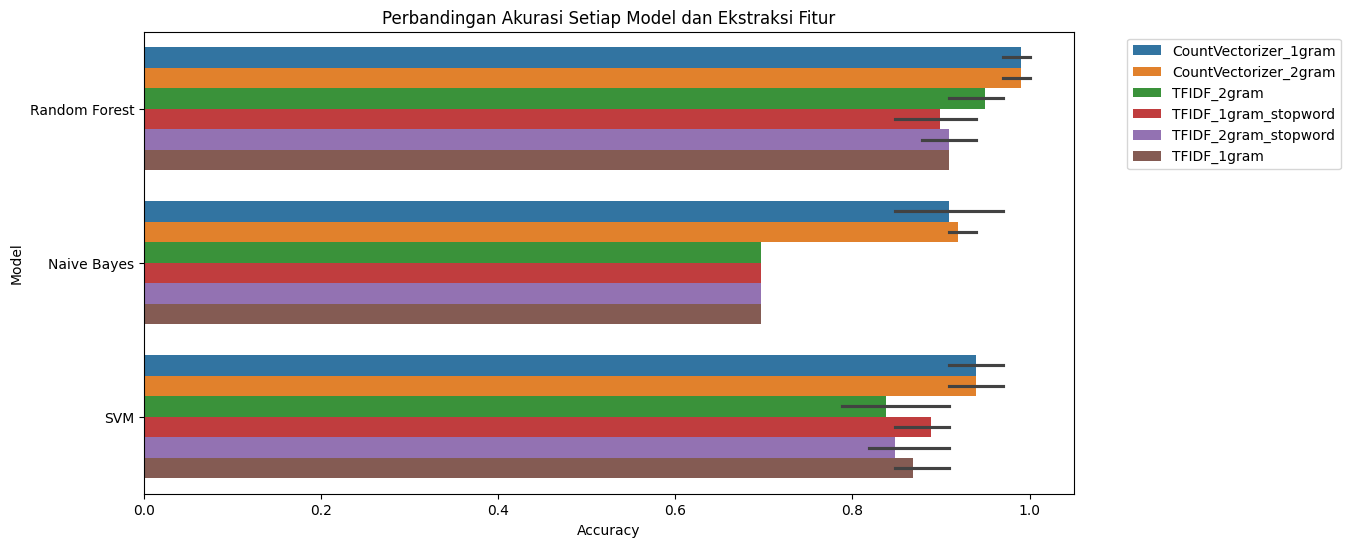

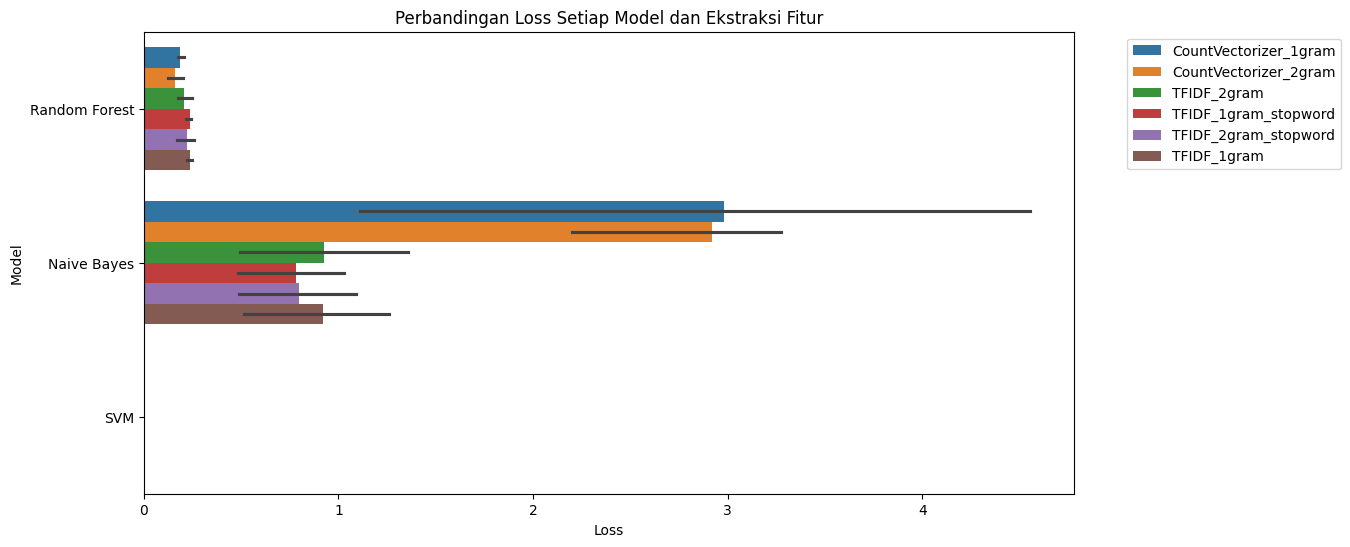


=== EKSPERIMEN TERBAIK ===
Vectorizer     CountVectorizer_1gram
Feature_Set            chi2_selected
Model                  Random Forest
Accuracy                         1.0
Loss                        0.176603
Name: 0, dtype: object

=== CLASSIFICATION REPORT (MODEL TERBAIK) ===
                 precision    recall  f1-score   support

pencurian_berat       0.96      1.00      0.98        23
pencurian_biasa       1.00      0.90      0.95        10

       accuracy                           0.97        33
      macro avg       0.98      0.95      0.96        33
   weighted avg       0.97      0.97      0.97        33



In [ ]:
# =====================================
# EXPERIMEN EKSTRAKSI FITUR & KLASIFIKASI TEKS PUTUSAN
# =====================================
!pip install -q Sastrawi
# --- Import Library ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.metrics import accuracy_score, classification_report, log_loss
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Buat daftar stopword Indonesia
factory = StopWordRemoverFactory()
stopword_list = factory.get_stop_words()

# --- Load Data ---
train_df = pd.read_csv('/content/drive/MyDrive/MESIN/data/processed/cases_train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/MESIN/data/processed/cases_test.csv')

# --- Cek struktur data ---
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print(train_df['jenis_perkara'].value_counts())

# --- Variabel ---
X_train = train_df['text_full'].fillna("")
y_train = train_df['label']
X_test = test_df['text_full'].fillna("")
y_test = test_df['label']

# =====================================
# DEFINISI MODEL
# =====================================
models = {
    'Naive Bayes': MultinomialNB(),
    'SVM': LinearSVC(),
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42)
}

# =====================================
# DEFINISI EKSPERIMEN EKSTRAKSI FITUR
# =====================================
vectorizers = {
    'CountVectorizer_1gram': CountVectorizer(ngram_range=(1,1)),
    'CountVectorizer_2gram': CountVectorizer(ngram_range=(1,2)),
    'TFIDF_1gram': TfidfVectorizer(ngram_range=(1,1)),
    'TFIDF_2gram': TfidfVectorizer(ngram_range=(1,2)),
    'TFIDF_1gram_stopword': TfidfVectorizer(ngram_range=(1,1), stop_words=stopword_list),
    'TFIDF_2gram_stopword': TfidfVectorizer(ngram_range=(1,2), stop_words=stopword_list),
}

# =====================================
# LOOP EKSPERIMEN
# =====================================
results = []

for vect_name, vect in vectorizers.items():
    print(f"\n=== Ekstraksi fitur: {vect_name} ===")
    X_train_vec = vect.fit_transform(X_train)
    X_test_vec = vect.transform(X_test)

    # Seleksi fitur 1: Chi-Square
    chi_selector = SelectKBest(chi2, k=min(3000, X_train_vec.shape[1]))
    X_train_chi = chi_selector.fit_transform(X_train_vec, y_train)
    X_test_chi = chi_selector.transform(X_test_vec)

    # Seleksi fitur 2: Mutual Information
    mi_selector = SelectKBest(mutual_info_classif, k=min(3000, X_train_vec.shape[1]))
    X_train_mi = mi_selector.fit_transform(X_train_vec, y_train)
    X_test_mi = mi_selector.transform(X_test_vec)

    feature_sets = {
        'original': (X_train_vec, X_test_vec),
        'chi2_selected': (X_train_chi, X_test_chi),
        'mutual_info_selected': (X_train_mi, X_test_mi)
    }

    for feature_name, (Xtr, Xts) in feature_sets.items():
        for model_name, model in models.items():
            print(f"→ Model: {model_name} | Fitur: {vect_name}_{feature_name}")
            model.fit(Xtr, y_train)
            y_pred = model.predict(Xts)
            acc = accuracy_score(y_test, y_pred)

            # log loss hanya untuk NB & RF (SVM tidak punya predict_proba)
            try:
                y_proba = model.predict_proba(Xts)
                loss = log_loss(y_test, y_proba)
            except:
                loss = np.nan

            results.append({
                'Vectorizer': vect_name,
                'Feature_Set': feature_name,
                'Model': model_name,
                'Accuracy': acc,
                'Loss': loss
            })

# =====================================
# HASIL EKSPERIMEN
# =====================================
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
print("\n===== HASIL EKSPERIMEN TERURUT =====")
display(results_df)

# Simpan hasil ke Google Drive
results_df.to_csv('/content/drive/MyDrive/MESIN/hasil_eksperimen_fitur_putusan.csv', index=False)

# =====================================
# VISUALISASI AKURASI & LOSS
# =====================================
plt.figure(figsize=(12,6))
sns.barplot(x='Accuracy', y='Model', hue='Vectorizer', data=results_df)
plt.title('Perbandingan Akurasi Setiap Model dan Ekstraksi Fitur')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.show()

plt.figure(figsize=(12,6))
sns.barplot(x='Loss', y='Model', hue='Vectorizer', data=results_df)
plt.title('Perbandingan Loss Setiap Model dan Ekstraksi Fitur')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.show()

# =====================================
# REPORT MODEL TERBAIK
# =====================================
best_exp = results_df.iloc[0]
print("\n=== EKSPERIMEN TERBAIK ===")
print(best_exp)

# Jalankan ulang eksperimen terbaik untuk classification report
best_vect = vectorizers[best_exp['Vectorizer']]
X_train_best = best_vect.fit_transform(X_train)
X_test_best = best_vect.transform(X_test)

best_model = models[best_exp['Model']]
best_model.fit(X_train_best, y_train)
y_pred_best = best_model.predict(X_test_best)

print("\n=== CLASSIFICATION REPORT (MODEL TERBAIK) ===")
print(classification_report(y_test, y_pred_best))


**Model RNN**

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/putusgan_preprocessed.csv')
df.head()


,judul,nomor,tingkat_proses,klasifikasi,kata_kunci,tahun,tanggal_register,lembaga_peradilan,jenis_lembaga_peradilan,hakim_ketua,...,kaidah,abstrak,link,link_pdf,file_name_pdf,text_pdf,Ringkasan_Manual,jenis_pencurian,kategori_pencurian,klasifikasi_pencurian
0,Putusan PN SAMARINDA Nomor 598/Pid.B/2024/PN S...,598/Pid.B/2024/PN Smr,Pertama,Pidana Umum \n Pidana Umum Pencurian,Pencurian,2024,12 Juli 2024,PN SAMARINDA,PN,Hakim Ketua Elin Pujiastuti,...,—,NaN,https://putusan3.mahkamahagung.go.id/direktori...,https://putusan3.mahkamahagung.go.id/direktori...,putusan_598_pid.b_2024_pn_smr_20251007204404.pdf,Direktori Putusan Mahkamah Agung Republik Indo...,Direktori Putusan Mahkamah Agung Republik Indo...,Pencurian Biasa,Ringan,NaN
1,Putusan PN SAMARINDA Nomor 768/Pid.B/2024/PN S...,768/Pid.B/2024/PN Smr,Pertama,Pidana Umum \n Pidana Umum Pencurian,Pencurian,2024,9 September 2024,PN SAMARINDA,PN,Hakim Ketua Elin Pujiastuti,...,—,NaN,https://putusan3.mahkamahagung.go.id/direktori...,https://putusan3.mahkamahagung.go.id/direktori...,putusan_768_pid.b_2024_pn_smr_20251007204420.pdf,Direktori Putusan Mahkamah Agung Republik Indo...,Direktori Putusan Mahkamah Agung Republik Indo...,Pencurian Biasa,Ringan,NaN
2,Putusan PN SAMARINDA Nomor 877/Pid.B/2024/PN S...,877/Pid.B/2024/PN Smr,Pertama,Pidana Umum \n Pidana Umum Pencurian,Pencurian,2024,14 Oktober 2024,PN SAMARINDA,PN,Hakim Ketua Lukman Akhmad,...,—,NaN,https://putusan3.mahkamahagung.go.id/direktori...,https://putusan3.mahkamahagung.go.id/direktori...,putusan_877_pid.b_2024_pn_smr_20251007204508.pdf,Direktori Putusan Mahkamah Agung Republik Indo...,Direktori Putusan Mahkamah Agung Republik Indo...,Pencurian Biasa,Ringan,NaN
3,Putusan PN SAMARINDA Nomor 646/Pid.B/2024/PN S...,646/Pid.B/2024/PN Smr,Pertama,Pidana Umum \n Pidana Umum Pencurian,Pencurian,2024,25 Juli 2024,PN SAMARINDA,PN,Hakim Ketua Agung Prasetyo,...,—,NaN,https://putusan3.mahkamahagung.go.id/direktori...,https://putusan3.mahkamahagung.go.id/direktori...,putusan_646_pid.b_2024_pn_smr_20251007204506.pdf,Direktori Putusan Mahkamah Agung Republik Indo...,Direktori Putusan Mahkamah Agung Republik Indo...,Pencurian Biasa,Ringan,NaN
4,Putusan PN SAMARINDA Nomor 1012/Pid.B/2024/PN ...,1012/Pid.B/2024/PN Smr,Pertama,Pidana Umum \n Pidana Umum Pencurian,Pencurian,2024,29 Nopember 2024,PN SAMARINDA,PN,Hakim Ketua Rida Nur Karima,...,—,NaN,https://putusan3.mahkamahagung.go.id/direktori...,https://putusan3.mahkamahagung.go.id/direktori...,putusan_1012_pid.b_2024_pn_smr_20251007204517.pdf,Direktori Putusan Mahkamah Agung Republik Indo...,Direktori Putusan Mahkamah Agung Republik Indo...,Pencurian Berat,Sedang,Pencurian dengan Kekerasan


In [ ]:
# Pilih kolom teks & label
X = df['text_pdf']
y = df['jenis_pencurian']

# Gabungkan sementara agar bisa drop NaN sekaligus
data = pd.DataFrame({"text": X, "label": y})

# Hapus baris yang kolomnya kosong
data = data.dropna()

# Kembalikan ke variabel X dan y yang sudah bersih
X = data['text']
y = data['label']


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 20000     # jumlah kosa kata unik maksimum
max_len = 200         # panjang maksimal setiap kalimat

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding="post")

# encode label
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

num_classes = len(le.classes_)
num_classes


2

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

embedding_dim = 128

model = Sequential([
    Embedding(max_words, embedding_dim),   # tanpa input_length
    LSTM(128, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(num_classes, activation="softmax")
])

model.build(input_shape=(None, max_len))
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 200, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,699,970 (10.30 MB)

 Trainable params: 2,699,970 (10.30 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)


In [ ]:
print("dtype y_train_enc:", y_train_enc.dtype)
print("unique labels:", set(y_train_enc))


dtype y_train_enc: int64
unique labels: {np.int64(0), np.int64(1)}


In [ ]:
model.compile(
    loss='sparse_categorical_crossentropy',  # ganti ini
    optimizer='adam',
    metrics=['accuracy']
)

history = model.fit(
    X_train_pad, y_train_enc,     # gunakan y_train, bukan y_train_enc
    epochs=10,
    batch_size=32,
    validation_split=0.2
)


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 464ms/step - accuracy: 0.4792 - loss: 0.6909 - val_accuracy: 0.7500 - val_loss: 0.6674
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 579ms/step - accuracy: 0.7617 - loss: 0.6490 - val_accuracy: 0.8500 - val_loss: 0.6119
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 362ms/step - accuracy: 0.7225 - loss: 0.5557 - val_accuracy: 0.8500 - val_loss: 0.5082
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step - accuracy: 0.7749 - loss: 0.4412 - val_accuracy: 0.9000 - val_loss: 0.4532
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step - accuracy: 0.8612 - loss: 0.3213 - val_accuracy: 0.9000 - val_loss: 0.3814
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step - accuracy: 0.8561 - loss: 0.3210 - val_accuracy: 0.9000 - val_loss: 0.3356
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step - accuracy: 0.8483 - loss: 0.3004 - val_accuracy: 0.9000 - val_loss: 0.3328
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step - accuracy: 0.8522 - loss: 0.3261 - val_accuracy: 0.9000 - val_loss:

In [ ]:
test_loss, test_acc = model.evaluate(X_test_pad, y_test_enc)
print("Test Accuracy:", test_acc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.8333 - loss: 0.3725
Test Accuracy: 0.8333333134651184


In [ ]:
loss, acc = model.evaluate(X_test_pad, y_test_enc)
print(f"Test Accuracy: {acc:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8333 - loss: 0.3725
Test Accuracy: 0.8333


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred = model.predict(X_test_pad)
y_pred_labels = np.argmax(y_pred, axis=1)

print(confusion_matrix(y_test_enc, y_pred_labels))
print(classification_report(y_test_enc, y_pred_labels, target_names=le.classes_))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
[[11  0]
 [ 4  9]]
                 precision    recall  f1-score   support

Pencurian Berat       0.73      1.00      0.85        11
Pencurian Biasa       1.00      0.69      0.82        13

       accuracy                           0.83        24
      macro avg       0.87      0.85      0.83        24
   weighted avg       0.88      0.83      0.83        24



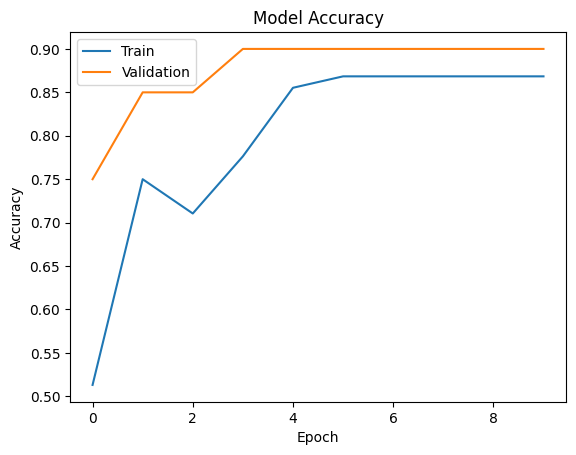

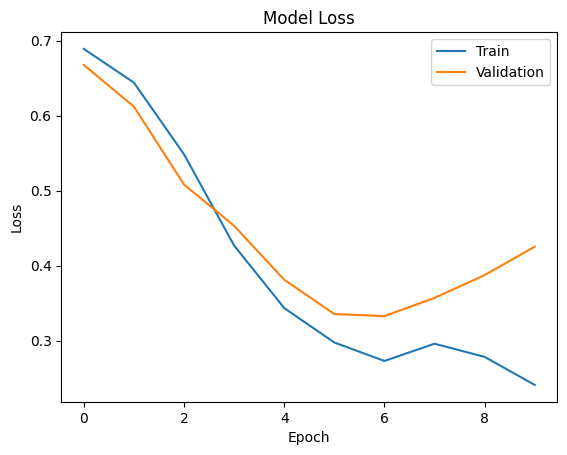

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()


In [ ]:
def predict_text(text):
    seq = tokenizer.texts_to_sequences([text])
    pad = pad_sequences(seq, maxlen=max_len, padding='post')
    pred = model.predict(pad)
    label = le.classes_[pred.argmax()]
    return label

predict_text("Terdakwa terbukti melakukan pencurian ayam")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


'Pencurian Biasa'

In [ ]:
def predict_text(text):
    seq = tokenizer.texts_to_sequences([text])
    pad = pad_sequences(seq, maxlen=max_len)
    pred = model.predict(pad)
    label = le.inverse_transform([np.argmax(pred)])
    return label[0]

predict_text("Terdakwa melakukan pencurian dengan pemberatan di malam hari.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


'Pencurian Berat'

**MODEL TRANSFER LEARNING (BERT)**

In [ ]:
!pip install transformers datasets torch scikit-learn pandas -q

In [ ]:
!pip install -q transformers datasets torch accelerate scikit-learn pandas

In [48]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

In [49]:
df = pd.read_csv("/content/preprocessed_pencurian.csv")

In [50]:
# Pastikan kolomnya benar
df = df[['text_pdf', 'label']].dropna().reset_index(drop=True)

# Ganti label jadi 0 dan 1
le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['label'])
11
print(f"Total data: {len(df)}")
print(f"Distribusi kelas:\n{df['label'].value_counts()}")

Total data: 116
Distribusi kelas:
label
pencurian berat    65
pencurian biasa    51
Name: count, dtype: int64


In [51]:
# 3. Split data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text_pdf'].tolist(),
    df['label_enc'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df['label_enc']
)

In [52]:
# 4. Load IndoBERT tokenizer & model
model_name = "indolem/indobert-base-uncased"  # Paling stabil & akurat untuk hukum Indonesia

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [53]:
# 5. Tokenisasi dengan max_length yang optimal untuk putusan (512 token cukup)
def tokenize_function(texts):
    return tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=512,        # Putusan panjang → 512 token cukup menangkap esensi
        return_tensors="pt"
    )

train_encodings = tokenize_function(train_texts)
val_encodings = tokenize_function(val_texts)

In [54]:
# 6. Buat Dataset PyTorch
class PutusanDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = PutusanDataset(train_encodings, train_labels)
val_dataset = PutusanDataset(val_encodings, val_labels)

In [55]:
# 7. Metrik evaluasi
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [56]:
training_args = TrainingArguments(
    output_dir="/content/indobert-pencurian",
    num_train_epochs=6,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    learning_rate=3e-5,
    warmup_steps=50,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,

    eval_strategy="epoch",     # FIXED
    save_strategy="epoch",

    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    fp16=True,
    seed=42,
    report_to="none"
)


In [57]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.601465,0.958333,0.958113,0.961310,0.958333
2,0.673300,0.260264,1.000000,1.000000,1.000000,1.000000
3,0.673300,0.094748,1.000000,1.000000,1.000000,1.000000
4,0.252900,0.018311,1.000000,1.000000,1.000000,1.000000
5,0.037300,0.005224,1.000000,1.000000,1.000000,1.000000
6,0.037300,0.001994,1.000000,1.000000,1.000000,1.000000


TrainOutput(global_step=36, training_loss=0.2684746836829517, metrics={'train_runtime': 3979.0144, 'train_samples_per_second': 0.139, 'train_steps_per_second': 0.009, 'total_flos': 145237302558720.0, 'train_loss': 0.2684746836829517, 'epoch': 6.0})

In [58]:
# 10. Evaluasi akhir
eval_result = trainer.evaluate()
print("HASIL AKHIR INDOBERT:")
print(f"Accuracy: {eval_result['eval_accuracy']:.4f}")
print(f"F1-Score: {eval_result['eval_f1']:.4f}")

HASIL AKHIR INDOBERT:
Accuracy: 1.0000
F1-Score: 1.0000



Classification Report:
                 precision    recall  f1-score   support

pencurian berat       1.00      1.00      1.00        13
pencurian biasa       1.00      1.00      1.00        11

       accuracy                           1.00        24
      macro avg       1.00      1.00      1.00        24
   weighted avg       1.00      1.00      1.00        24



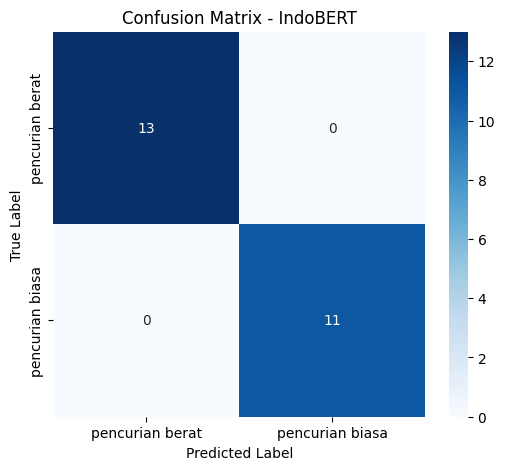

In [64]:
# Prediksi & laporan lengkap
predictions = trainer.predict(val_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = val_labels

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Hitung confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = le.classes_

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.title("Confusion Matrix - IndoBERT")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

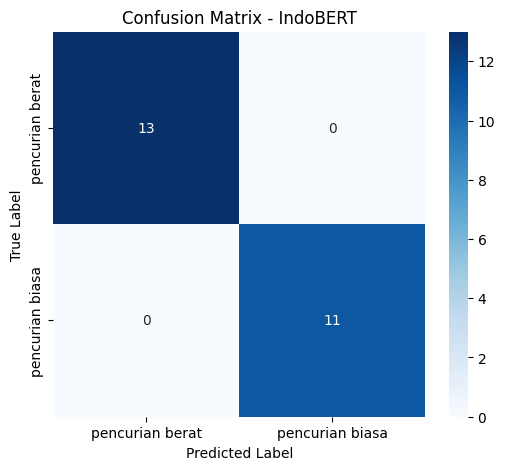

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Hitung confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = le.classes_

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.title("Confusion Matrix - IndoBERT")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()